# River Tree

An example workflow for gathering NHD Plus data and generating a tree.

In [1]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging

import workflow
import workflow.source_list
import workflow.conf
import workflow.ui
import workflow.utils
import workflow.plot

workflow.conf.rcParams['data dir'] = os.path.join(os.getcwd(),'..','data')

workflow.ui.setup_logging(1,None)

In [2]:
# open a shapefile for use here
manager_shp = workflow.source_list.FileManagerShape('../data/hydrologic_units/others/Coweeta/coweeta_basin.shp')
shp_profile,shp = manager_shp.get_shape()
shply = workflow.utils.shply(shp)

In [3]:
# find the rivers in this shape
reaches, _ = workflow.get_rivers_by_bounds(workflow.source_list.hydrography_sources['NHD Plus'],
                                               shply.bounds, shp_profile['crs'], '0601', merge=False)

# filter the list to only those that intersect the shape
reaches = workflow.hydrography.filter_rivers_to_shape(shply, reaches, 10)

# make the global tree
rivers = workflow.hydrography.make_global_tree(reaches)

# check that only one tree was formed (this means al)
assert(len(rivers) is 1)
river = rivers[0]

2019-08-01 23:35:08,382 - root - INFO: 
2019-08-01 23:35:08,384 - root - INFO: Preprocessing Hydrography
2019-08-01 23:35:08,385 - root - INFO: ------------------------------
2019-08-01 23:35:08,386 - root - INFO: loading streams in bounds (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2019-08-01 23:35:08,389 - root - INFO: Using Hydrography file "/Users/uec/research/water/data/meshing/examples/../data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2019-08-01 23:35:09,903 - root - INFO:   ...filtering


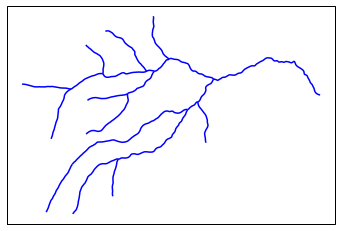

In [4]:
workflow.plot.rivers([river,], shp_profile['crs'])

In [5]:
for r in river:
    print(r.properties)

OrderedDict([('Permanent_Identifier', '90511868'), ('FDate', '2011-12-21T03:18:18'), ('Resolution', 2), ('GNIS_ID', '01010529'), ('GNIS_Name', 'Coweeta Creek'), ('LengthKM', 2.825), ('ReachCode', '06010202000091'), ('FlowDir', 1), ('WBArea_Permanent_Identifier', None), ('FType', 460), ('FCode', 46006), ('MainPath', 0), ('InNetwork', 1), ('VisibilityFilter', 2000000), ('Shape_Length', 0.02933313696587409), ('NHDPlusID', 25000400040729.0), ('VPUID', '0601'), ('Enabled', 1)])
OrderedDict([('Permanent_Identifier', '90511918'), ('FDate', '2011-12-21T03:18:20'), ('Resolution', 2), ('GNIS_ID', '01008893'), ('GNIS_Name', 'Ball Creek'), ('LengthKM', 0.619), ('ReachCode', '06010202000092'), ('FlowDir', 1), ('WBArea_Permanent_Identifier', None), ('FType', 460), ('FCode', 46006), ('MainPath', 0), ('InNetwork', 1), ('VisibilityFilter', 500000), ('Shape_Length', 0.006007203236050549), ('NHDPlusID', 25000400108020.0), ('VPUID', '0601'), ('Enabled', 1)])
OrderedDict([('Permanent_Identifier', '90511928

In [9]:
import fiona
fiona.listlayers('../data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb')

['ExternalCrosswalk',
 'FeatureToMetadata',
 'HUMod',
 'NHDFCode',
 'NHDFeatureToMetadata',
 'NHDMetadata',
 'NHDPlusDivFracMP',
 'NHDPlusEROMMA',
 'NHDPlusEROMQAMA',
 'NHDPlusEROMQARPT',
 'NHDPlusFlow',
 'NHDPlusFlowlineVAA',
 'NHDPlusIncrLat',
 'NHDPlusIncrPrecipMA',
 'NHDPlusIncrPrecipMM01',
 'NHDPlusIncrPrecipMM02',
 'NHDPlusIncrPrecipMM03',
 'NHDPlusIncrPrecipMM04',
 'NHDPlusIncrPrecipMM05',
 'NHDPlusIncrPrecipMM06',
 'NHDPlusIncrPrecipMM07',
 'NHDPlusIncrPrecipMM08',
 'NHDPlusIncrPrecipMM09',
 'NHDPlusIncrPrecipMM10',
 'NHDPlusIncrPrecipMM11',
 'NHDPlusIncrPrecipMM12',
 'NHDPlusIncrROMA',
 'NHDPlusIncrTempMA',
 'NHDPlusIncrTempMM01',
 'NHDPlusIncrTempMM02',
 'NHDPlusIncrTempMM03',
 'NHDPlusIncrTempMM04',
 'NHDPlusIncrTempMM05',
 'NHDPlusIncrTempMM06',
 'NHDPlusIncrTempMM07',
 'NHDPlusIncrTempMM08',
 'NHDPlusIncrTempMM09',
 'NHDPlusIncrTempMM10',
 'NHDPlusIncrTempMM11',
 'NHDPlusIncrTempMM12',
 'NHDPlusMegaDiv',
 'NHDPlusNHDPlusIDGridCode',
 'NHDProcessingParameters',
 'NHDReachCo

In [10]:
fid = fiona.open('../data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb', 'r', layer='NHDPlusFlowlineVAA')

In [13]:
fid[10]

{'type': 'Feature',
 'id': '10',
 'properties': OrderedDict([('NHDPlusID', 25000400123673.0),
              ('StreamLeve', 3),
              ('StreamOrde', 1),
              ('StreamCalc', 1),
              ('FromNode', 25000400204878.0),
              ('ToNode', 25000400125642.0),
              ('HydroSeq', 25000400215041.0),
              ('LevelPathI', 25000400215041.0),
              ('PathLength', 1300.41688666),
              ('TerminalPa', 25000100000172.0),
              ('ArbolateSu', 0.41714276),
              ('Divergence', 0),
              ('StartFlag', 1),
              ('TerminalFl', 0),
              ('UpLevelPat', 0.0),
              ('UpHydroSeq', 0.0),
              ('DnLevel', 2),
              ('DnLevelPat', 25000400050822.0),
              ('DnHydroSeq', 25000400064378.0),
              ('DnMinorHyd', 0.0),
              ('DnDrainCou', 1),
              ('FromMeas', 0.0),
              ('ToMeas', 100.0),
              ('ReachCode', '06010105105370'),
             

In [15]:
len(fida)


293